# ***INDOBERT  fine-tuning***

In [1]:
import numpy as np
from transformers import TrainingArguments, Trainer, BertForSequenceClassification, BertTokenizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
import time

In [2]:
!pip install transformers[torch]
!pip install datasets
!pip install scikit-learn

In [3]:
df = pd.read_csv("final_preprocessing.csv")
df.head()

,comment,cleaned_comment,case_folding,normalization,label
0,Gambar kebaretnya boongan ternyata,Gambar kebaretnya boongan ternyata,gambar kebaretnya boongan ternyata,gambar kebaretnya boongan ternyata,0
1,"Buat pemakai biasa sama saja iphone 16 promax,...",Buat pemakai biasa sama saja iphone 16 promax ...,buat pemakai biasa sama saja iphone 16 promax ...,buat pemakai biasa sama saja iphone 16 promax ...,0
2,Case poco&quot; ??,Case pocoquot,case pocoquot,case pocoquot,1
3,Kaum miFans dan kaum munafik iri dengki lg kum...,Kaum miFans dan kaum munafik iri dengki lg kum...,kaum mifans dan kaum munafik iri dengki lg kum...,kaum mifans dan kaum munafik iri dengki lagi k...,0
4,Saya mah nunggu S26 Ultra aja,Saya mah nunggu S26 Ultra aja,saya mah nunggu s26 ultra aja,saya mah menunggu s26 ultra saja,0


In [4]:
df = df.dropna().reset_index(drop=True)

In [5]:
train_df, test_df = train_test_split(df,test_size=0.2,random_state=42, stratify=df['label'])

In [6]:
model_name = "indobenchmark/indobert-base-p1"
tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [7]:
def tokenize_function(example):
    return {
        **tokenizer(example["normalization"], truncation=True),
        'labels': example['label']
    }

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

columns_to_remove = ['comment', 'cleaned_comment', 'case_folding', 'normalization']

train_dataset = train_dataset.remove_columns(columns_to_remove)
test_dataset = test_dataset.remove_columns(columns_to_remove)

train_dataset.set_format("torch")
test_dataset.set_format("torch")

print("\nExample of tokenized comment:")
print(train_dataset[0])

Map:   0%|          | 0/3272 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/818 [00:00<?, ? examples/s]


Example of tokenized comment:
{'label': tensor(2), '__index_level_0__': tensor(1556), 'input_ids': tensor([    2,   339, 19760,  1229,   216,  3107,    92,  2824,  8433,    34,
          364,  7370,   804,   366,     3]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'labels': tensor(2)}


In [8]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_score": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }
grid = [
    {"learning_rate": 2e-5, "batch_size": 8,  "epochs": 3},
    {"learning_rate": 2e-5, "batch_size": 8,  "epochs": 4},
    {"learning_rate": 3e-5, "batch_size": 8,  "epochs": 4},
    {"learning_rate": 3e-5, "batch_size": 16, "epochs": 3},
    {"learning_rate": 5e-5, "batch_size": 16, "epochs": 4},
]

results = []
best_f1 = -1
best_config = None
best_metrics = None

In [ ]:
for i, params in enumerate(grid):
    print("\n===============================")
    print(f"Running config {i+1}/{len(grid)}: {params}")
    print("===============================")

    # Reload fresh model for each trial
    model = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=3
    )

    training_args = TrainingArguments(
        output_dir=f"./indobert_tuning_run_{i}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=params["learning_rate"],
        per_device_train_batch_size=params["batch_size"],
        per_device_eval_batch_size=params["batch_size"],
        num_train_epochs=params["epochs"],
        weight_decay=0.01,
        logging_steps=10,
        load_best_model_at_end=True,
        report_to="none",
        save_total_limit=1
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    start = time.time()
    trainer.train()
    print("Training time:", time.time() - start)

    metrics = trainer.evaluate()
    print("Metrics:", metrics)

    results.append((params, metrics))

    # Track best model via weighted f1
    if metrics["eval_f1_score"] > best_f1:
        best_f1 = metrics["eval_f1_score"]
        best_config = params
        best_metrics = metrics

print("\n===============================")
print("BEST CONFIGURATION FOUND")
print("===============================")
print(best_config)
print("\nBEST METRICS")
print(best_metrics)



Running config 1/5: {'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 3}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2671172127.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
1,0.594600,0.614541,0.756724,0.747523,0.745849,0.756724
2,0.467400,0.764089,0.744499,0.732829,0.732652,0.744499
3,0.347600,0.967300,0.757946,0.754308,0.752147,0.757946


Training time: 180.09595227241516


Metrics: {'eval_loss': 0.6145408749580383, 'eval_accuracy': 0.7567237163814181, 'eval_f1_score': 0.7475227177538656, 'eval_precision': 0.7458493356328597, 'eval_recall': 0.7567237163814181, 'eval_runtime': 2.8472, 'eval_samples_per_second': 287.296, 'eval_steps_per_second': 36.175, 'epoch': 3.0}

Running config 2/5: {'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 4}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2671172127.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
1,0.610600,0.610001,0.750611,0.739129,0.743360,0.750611
2,0.533500,0.769499,0.735941,0.717921,0.732978,0.735941
3,0.373300,1.038622,0.754279,0.750237,0.748438,0.754279
4,0.156600,1.328802,0.746944,0.741638,0.739414,0.746944


Training time: 236.5223982334137


Metrics: {'eval_loss': 0.6100011467933655, 'eval_accuracy': 0.7506112469437652, 'eval_f1_score': 0.7391285318889622, 'eval_precision': 0.7433598265618863, 'eval_recall': 0.7506112469437652, 'eval_runtime': 3.8528, 'eval_samples_per_second': 212.311, 'eval_steps_per_second': 26.734, 'epoch': 4.0}

Running config 3/5: {'learning_rate': 3e-05, 'batch_size': 8, 'epochs': 4}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2671172127.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
1,0.559200,0.661979,0.750611,0.738393,0.741536,0.750611
2,0.472400,0.796333,0.743276,0.726150,0.735946,0.743276
3,0.464400,1.161981,0.734719,0.734290,0.737929,0.734719
4,0.131100,1.384373,0.748166,0.744270,0.741902,0.748166


Training time: 254.9635739326477


Metrics: {'eval_loss': 0.6619792580604553, 'eval_accuracy': 0.7506112469437652, 'eval_f1_score': 0.738393173378985, 'eval_precision': 0.7415358047965143, 'eval_recall': 0.7506112469437652, 'eval_runtime': 2.7876, 'eval_samples_per_second': 293.437, 'eval_steps_per_second': 36.949, 'epoch': 4.0}

Running config 4/5: {'learning_rate': 3e-05, 'batch_size': 16, 'epochs': 3}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2671172127.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
1,0.630200,0.623484,0.746944,0.739365,0.741624,0.746944
2,0.400400,0.708890,0.729829,0.722300,0.722201,0.729829
3,0.219200,0.886407,0.746944,0.741470,0.738561,0.746944


Training time: 169.3967800140381


Metrics: {'eval_loss': 0.6234838366508484, 'eval_accuracy': 0.7469437652811736, 'eval_f1_score': 0.7393646849095966, 'eval_precision': 0.7416238182189429, 'eval_recall': 0.7469437652811736, 'eval_runtime': 3.1533, 'eval_samples_per_second': 259.411, 'eval_steps_per_second': 16.491, 'epoch': 3.0}

Running config 5/5: {'learning_rate': 5e-05, 'batch_size': 16, 'epochs': 4}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2671172127.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
1,0.689100,0.618763,0.745721,0.732718,0.735186,0.745721
2,0.438500,0.706346,0.745721,0.729245,0.733951,0.745721
3,0.219500,0.909322,0.748166,0.749250,0.752185,0.748166
4,0.118700,1.205039,0.753056,0.748812,0.746517,0.753056


Training time: 232.50204277038574


Metrics: {'eval_loss': 0.6187631487846375, 'eval_accuracy': 0.7457212713936431, 'eval_f1_score': 0.7327176562276408, 'eval_precision': 0.7351859695818732, 'eval_recall': 0.7457212713936431, 'eval_runtime': 3.1104, 'eval_samples_per_second': 262.992, 'eval_steps_per_second': 16.718, 'epoch': 4.0}

BEST CONFIGURATION FOUND
{'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 3}

BEST METRICS
{'eval_loss': 0.6145408749580383, 'eval_accuracy': 0.7567237163814181, 'eval_f1_score': 0.7475227177538656, 'eval_precision': 0.7458493356328597, 'eval_recall': 0.7567237163814181, 'eval_runtime': 2.8472, 'eval_samples_per_second': 287.296, 'eval_steps_per_second': 36.175, 'epoch': 3.0}


In [11]:
print("\nRetraining IndoBERT with best configuration...")

best_model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
)

best_args = TrainingArguments(
    output_dir="./indobert_best_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_config["learning_rate"],
    per_device_train_batch_size=best_config["batch_size"],
    per_device_eval_batch_size=best_config["batch_size"],
    num_train_epochs=best_config["epochs"],
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    report_to="none",
    save_total_limit=1
)

best_trainer = Trainer(
    model=best_model,
    args=best_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

best_trainer.train()

best_checkpoint = best_trainer.state.best_model_checkpoint
best_trainer.model = BertForSequenceClassification.from_pretrained(best_checkpoint, num_labels=3)


Retraining IndoBERT with best configuration...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-310996999.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
1,0.655700,0.615377,0.751834,0.743072,0.743090,0.751834
2,0.515100,0.722199,0.753056,0.740816,0.739745,0.753056
3,0.355300,0.995482,0.737164,0.730979,0.727379,0.737164



CLASSIFICATION REPORT — Best IndoBERT Model

              precision    recall  f1-score   support

    Negative       0.74      0.77      0.75       308
     Neutral       0.78      0.82      0.80       431
    Positive       0.57      0.30      0.40        79

    accuracy                           0.75       818
   macro avg       0.70      0.63      0.65       818
weighted avg       0.74      0.75      0.74       818



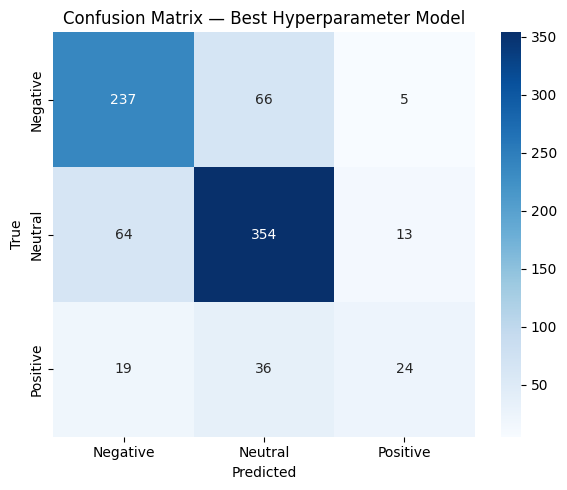

In [13]:
best_checkpoint = best_trainer.state.best_model_checkpoint
best_trainer.model = BertForSequenceClassification.from_pretrained(best_checkpoint, num_labels=3)

# move to GPU
import torch
if torch.cuda.is_available():
    best_trainer.model.to("cuda")

pred_output = best_trainer.predict(test_dataset)

logits = pred_output.predictions
preds = np.argmax(logits, axis=-1)
true = pred_output.label_ids

label_names = ["Negative", "Neutral", "Positive"]

print("\nCLASSIFICATION REPORT — Best IndoBERT Model\n")
print(classification_report(true, preds, target_names=label_names))

cm = confusion_matrix(true, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Best Hyperparameter Model")
plt.tight_layout()
plt.show()


**Class Weighting**

In [14]:
from sklearn.utils.class_weight import compute_class_weight
import torch
labels = train_df['label'].values
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)



In [16]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [17]:
for i, params in enumerate(grid):
    print("\n===============================")
    print(f"Running config {i+1}/{len(grid)}: {params}")
    print("===============================")

    model = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=3
    )

    training_args = TrainingArguments(
        output_dir=f"./indobert_tuning_run_{i}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=params["learning_rate"],
        per_device_train_batch_size=params["batch_size"],
        per_device_eval_batch_size=params["batch_size"],
        num_train_epochs=params["epochs"],
        weight_decay=0.01,
        logging_steps=10,
        load_best_model_at_end=True,
        report_to="none",
        save_total_limit=1
    )

    # USE WEIGHTED TRAINER
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    start = time.time()
    trainer.train()
    print("Training time:", time.time() - start)

    metrics = trainer.evaluate()
    print("Metrics:", metrics)

    results.append((params, metrics))

    if metrics["eval_f1_score"] > best_f1:
        best_f1 = metrics["eval_f1_score"]
        best_config = params
        best_metrics = metrics

print("\n===============================")
print("BEST CONFIGURATION FOUND")
print("===============================")
print(best_config)
print("\nBEST METRICS")
print(best_metrics)



Running config 1/5: {'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 3}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3826920022.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
1,0.768600,0.751050,0.733496,0.735932,0.742844,0.733496
2,0.534000,1.096005,0.744499,0.736804,0.734420,0.744499
3,0.367600,1.260756,0.749389,0.747172,0.746428,0.749389


Training time: 208.80652809143066


Metrics: {'eval_loss': 0.7510496973991394, 'eval_accuracy': 0.7334963325183375, 'eval_f1_score': 0.7359319780332912, 'eval_precision': 0.7428441743664718, 'eval_recall': 0.7334963325183375, 'eval_runtime': 2.6342, 'eval_samples_per_second': 310.535, 'eval_steps_per_second': 39.102, 'epoch': 3.0}

Running config 2/5: {'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 4}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3826920022.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
1,0.803300,0.776657,0.705379,0.710342,0.731264,0.705379
2,0.538300,1.227105,0.742054,0.731304,0.732320,0.742054
3,0.433700,1.529141,0.728606,0.725633,0.723220,0.728606
4,0.112500,1.884608,0.742054,0.737395,0.735496,0.742054


Training time: 226.00770354270935


Metrics: {'eval_loss': 0.7766565680503845, 'eval_accuracy': 0.7053789731051344, 'eval_f1_score': 0.7103416096523721, 'eval_precision': 0.7312639580345625, 'eval_recall': 0.7053789731051344, 'eval_runtime': 2.6768, 'eval_samples_per_second': 305.585, 'eval_steps_per_second': 38.478, 'epoch': 4.0}

Running config 3/5: {'learning_rate': 3e-05, 'batch_size': 8, 'epochs': 4}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3826920022.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
1,0.770000,0.825157,0.700489,0.701038,0.712477,0.700489
2,0.594800,1.277103,0.724939,0.712917,0.710506,0.724939
3,0.363900,1.502793,0.716381,0.716212,0.716052,0.716381
4,0.123000,2.026625,0.724939,0.720792,0.718658,0.724939


Training time: 285.7096321582794


Metrics: {'eval_loss': 0.8251573443412781, 'eval_accuracy': 0.7004889975550123, 'eval_f1_score': 0.7010383785203647, 'eval_precision': 0.7124768353081311, 'eval_recall': 0.7004889975550123, 'eval_runtime': 2.6325, 'eval_samples_per_second': 310.726, 'eval_steps_per_second': 39.126, 'epoch': 4.0}

Running config 4/5: {'learning_rate': 3e-05, 'batch_size': 16, 'epochs': 3}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3826920022.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
1,0.792100,0.742442,0.655257,0.678749,0.760163,0.655257
2,0.436300,0.961309,0.713936,0.718011,0.723174,0.713936
3,0.248100,1.212922,0.740831,0.740544,0.741006,0.740831


Training time: 198.76210379600525


Metrics: {'eval_loss': 0.7424420118331909, 'eval_accuracy': 0.6552567237163814, 'eval_f1_score': 0.6787491950046368, 'eval_precision': 0.7601629459601508, 'eval_recall': 0.6552567237163814, 'eval_runtime': 3.1898, 'eval_samples_per_second': 256.446, 'eval_steps_per_second': 16.302, 'epoch': 3.0}

Running config 5/5: {'learning_rate': 5e-05, 'batch_size': 16, 'epochs': 4}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3826920022.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
1,0.801200,0.782055,0.629584,0.653209,0.742727,0.629584
2,0.584000,1.142292,0.738386,0.731642,0.729305,0.738386
3,0.183400,1.372468,0.754279,0.755161,0.757446,0.754279
4,0.087600,1.780478,0.759169,0.754352,0.751796,0.759169


Training time: 257.914489030838


Metrics: {'eval_loss': 0.7820553779602051, 'eval_accuracy': 0.6295843520782396, 'eval_f1_score': 0.6532089535609215, 'eval_precision': 0.7427270339096445, 'eval_recall': 0.6295843520782396, 'eval_runtime': 3.0161, 'eval_samples_per_second': 271.214, 'eval_steps_per_second': 17.241, 'epoch': 4.0}

BEST CONFIGURATION FOUND
{'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 3}

BEST METRICS
{'eval_loss': 0.7510496973991394, 'eval_accuracy': 0.7334963325183375, 'eval_f1_score': 0.7359319780332912, 'eval_precision': 0.7428441743664718, 'eval_recall': 0.7334963325183375, 'eval_runtime': 2.6342, 'eval_samples_per_second': 310.535, 'eval_steps_per_second': 39.102, 'epoch': 3.0}


In [19]:
from torch.nn import CrossEntropyLoss

best_model.classifier = best_model.classifier
best_model.loss_fct = CrossEntropyLoss(weight=class_weights)

training_args = TrainingArguments(
    output_dir="./indobert_best_weighted",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_config["learning_rate"],
    per_device_train_batch_size=best_config["batch_size"],
    per_device_eval_batch_size=best_config["batch_size"],
    num_train_epochs=best_config["epochs"],
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    report_to="none",
    save_total_limit=1
)

cw_trainer = Trainer(
    model=best_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

cw_trainer.train()

cw_pred = cw_trainer.predict(test_dataset)
cw_y_true = cw_pred.label_ids
cw_y_pred = np.argmax(cw_pred.predictions, axis=1)


/tmp/ipython-input-3164644433.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  cw_trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
1,0.422700,0.840456,0.744499,0.740400,0.739450,0.744499
2,0.364600,1.238491,0.733496,0.722804,0.725200,0.733496
3,0.266200,1.434345,0.737164,0.733842,0.731551,0.737164



CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.7126    0.7727    0.7414       308
           1     0.8009    0.7935    0.7972       431
           2     0.5088    0.3671    0.4265        79

    accuracy                         0.7445       818
   macro avg     0.6741    0.6444    0.6550       818
weighted avg     0.7394    0.7445    0.7404       818


CONFUSION MATRIX
[[238  58  12]
 [ 73 342  16]
 [ 23  27  29]]


Accuracy: 0.7444987775061125

Classification Report:
               precision    recall  f1-score   support

    Negative       0.71      0.77      0.74       308
     Neutral       0.80      0.79      0.80       431
    Positive       0.51      0.37      0.43        79

    accuracy                           0.74       818
   macro avg       0.67      0.64      0.66       818
weighted avg       0.74      0.74      0.74       818



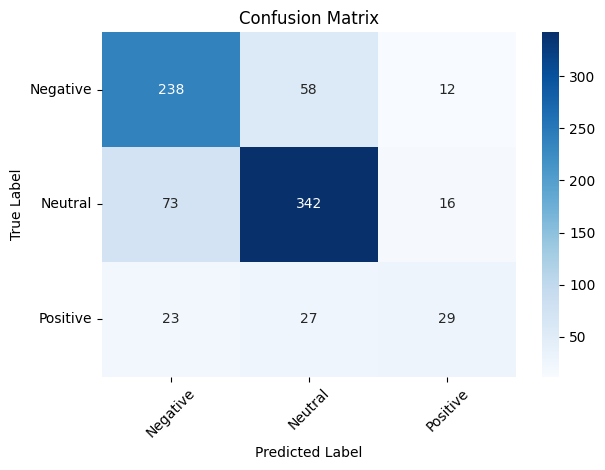

In [21]:
from sklearn.utils.multiclass import unique_labels

all_label_names = ['Negative', 'Neutral', 'Positive']

labels_in_data = sorted(list(unique_labels(cw_y_true, cw_y_pred)))
used_label_names = [all_label_names[i] for i in labels_in_data]

print("Accuracy:", accuracy_score(cw_y_true, cw_y_pred))
print("\nClassification Report:\n", classification_report(cw_y_true, cw_y_pred, target_names=used_label_names))

cm = confusion_matrix(cw_y_true, cw_y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=used_label_names, yticklabels=used_label_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
